Example using mnist
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py

Geron Text about Classifiers: https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib

In [5]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

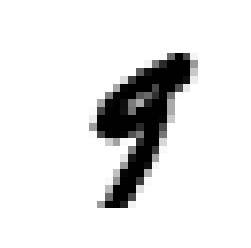

In [6]:
#looking at one of the digits in the dataset
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
#looks like a 9, lets check
y[36000]

'9'

In [8]:
#creating train/test split data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
np.unique(y_train_5)

NameError: name 'y_train_5' is not defined

In [10]:
#What happened is that you used fetch_openml() to download MNIST, and it returns 
#labels as strings so when you defined y_train_5 = (y_train == 5), it results an array full of False. See above cell.
#Fix
y_train = y_train.astype(np.int8)

In [35]:
np.unique(y_train_5)

array([False,  True])

In [11]:
#shuffling training set to guarantee that all cross-validation folds will
#be similar (you don’t want one fold to be missing some digits)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. 

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)


In [13]:
# Let’s create an SGDClassifier and train it on the whole training set:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
 sgd_clf.predict([some_digit])

array([False])

#### Performance Measures

#### Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what
cross_val_score() and similar functions provide. In these cases, you can implement
cross-validation yourself; it is actually fairly straightforward. The following code does
roughly the same thing as the preceding cross_val_score() code, and prints the
same result:


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96925
0.9599
0.9617


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [16]:
# Using cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds.
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96925, 0.9599 , 0.9617 ])

Both previous validations showed high accuracy in predictions for the not-5 class. Is that good? Let's check using a 'dumb' classifier

In [2]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.9088 , 0.91   , 0.91015])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if
you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent
than others).

### Confusion Matrix


The
general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5throw and 3rd column of the confusion matrix. To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to
the actual targets.


In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation,
but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means
that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is
made by a model that never saw the data during training).
Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the
target classes (y_train_5) and the predicted classes (y_train_pred)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53842,   737],
       [ 1446,  3975]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted
class. The first row of this matrix considers non-5 images (the negative class): 53,272 of them were
correctly classified as non-5s (they are called true negatives), while the remaining 1,307 were wrongly
classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,077
were wrongly classified as non-5s (false negatives), while the remaining 4,344 were correctly classified
as 5s (true positives). A perfect classifier would have only true positives and true negatives.


### Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score
print('precision ', precision_score(y_train_5, y_train_pred))

print('recall ', recall_score(y_train_5, y_train_pred))

precision  0.8435908319185059
recall  0.7332595462091865


Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an
image represents a 5, it is correct only 77% of the time. Moreover, it only detects 80% of the 5s

It is often convenient to combine precision and recall into a single metric called the F1 score, in
particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of
precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic
mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if
both recall and precision are high.

In [26]:
from sklearn.metrics import f1_score
print('f1_score ', f1_score(y_train_5, y_train_pred))

f1_score  0.7845652817526892


Using Thresholds with Precision and Recall:
Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores
that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its
decision_function() method, which returns a score for each instance, and then make predictions based
on those scores using any threshold you want:

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-450351.24681135])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

So how can you decide which threshold to use? For this you will first need to get the scores of all
instances in the training set using the cross_val_predict() function again, but this time specifying that
you want it to return decision scores instead of predictions:

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                              method="decision_function")


Now with these scores you can compute precision and recall for all possible thresholds using the
precision_recall_curve() function:

In [40]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

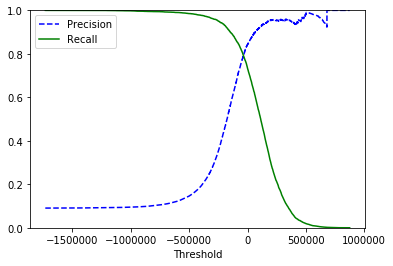

In [41]:
#Finally, you can plot precision and recall as functions of the threshold value using Matplotlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and
find that you need to use a threshold of about 70,000. To make predictions (on the training set for now),
instead of calling the classifier’s predict() method, you can just run this code

In [42]:
y_train_pred_90 = (y_scores > 70000)

In [44]:
#Let’s check these predictions’ precision and recall:
print(precision_score(y_train_5, y_train_pred_90))

print(recall_score(y_train_5, y_train_pred_90))


0.903560414914494
0.5945397528131341


###  The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.
It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC
curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the
ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true
negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR
is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the
roc_curve() function:

In [45]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

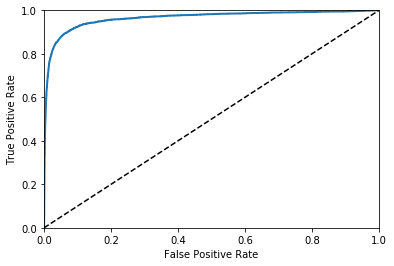

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier
produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays
as far away from that line as possible (toward the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will
have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.
Scikit-Learn provides a function to compute the ROC AUC:

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9645083953132704

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the
SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it
works (see Chapter 7), the RandomForestClassifier class does not have a decision_function()
method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the
other. The predict_proba() method returns an array containing a row per instance and a column per
class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance
that the image represents a 5):


In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                method="predict_proba")

In [49]:
#But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive
#class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

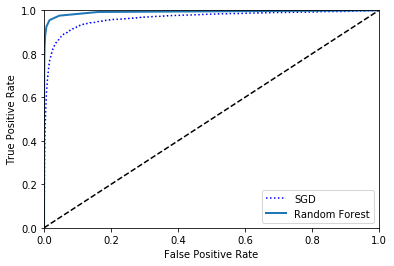

In [50]:
#Plot the curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9923870382403134

In [52]:
#the Random Forest curve is much better than the SGD curve, closer to the top left corner. Higher ROC AUC score as well

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called
multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling
multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are
strictly binary classifiers. However, there are various strategies that you can use to perform multiclass
classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is
to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then
when you want to classify an image, you get the decision score from each classifier for that image and you
select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA)
strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s,
another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one
(OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification
task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with
the SGDClassifier:


In [53]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([9], dtype=int8)

That was easy! This code trains the SGDClassifier on the training set using the original target classes
from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction
(a correct one in this case). Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their
decision scores for the image, and selected the class with the highest score.
To see that this is indeed the case, you can call the decision_function() method. Instead of returning
just one score per instance, it now returns 10 scores, one per class:

In [54]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-875899.27059489, -304155.47677197, -832804.49657476,
        -286504.55063628, -387218.5375092 , -450351.24681135,
        -727200.40455715, -218704.86466945, -268693.9863816 ,
         -77354.54033648]])

In [55]:
np.argmax(some_digit_scores)

9

In [59]:
#The highest score is indeed the one corresponding to class 9:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the
OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a binary
classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy,
based on a SGDClassifier:

In [60]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=int8)

In [61]:
len(ovo_clf.estimators_)

45

In [62]:
#Training a RandomForestClassifier is just as easy:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=int8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly
classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that
the classifier assigned to each instance for each class:


In [63]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

You can see that the classifier is fairly confident about its prediction: the 0.8 at the 5th index in the array means that the model estimates an 80% probability that the image represents a 5. It also thinks that the image could instead be a 0 or a 3 (10% chance each). Now of course you want to evaluate these classifiers. As usual, you want to use cross-validation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function:

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87517497, 0.86154308, 0.86783017])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is
not such a bad score, but you can still do much better. For example, simply scaling the inputs (as
discussed in Chapter 2) increases accuracy above 90%:

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90926815, 0.91169558, 0.90738611])

### Error Analysis
Here, we will assume that you have found a promising model
and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.
First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier:

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5723,    2,   21,    9,   10,   55,   50,   10,   38,    5],
       [   2, 6495,   43,   32,    5,   38,    9,   11,   96,   11],
       [  56,   38, 5319,   96,   80,   33,  106,   49,  165,   16],
       [  53,   44,  150, 5324,    2,  233,   36,   54,  145,   90],
       [  19,   29,   43,   10, 5355,   13,   60,   34,   78,  201],
       [  63,   48,   34,  184,   70, 4609,  109,   27,  188,   89],
       [  32,   24,   39,    2,   38,  100, 5635,    6,   41,    1],
       [  21,   22,   67,   29,   60,   12,    9, 5797,   17,  231],
       [  51,  160,   67,  149,   13,  164,   60,   23, 5047,  117],
       [  42,   34,   26,   92,  169,   33,    2,  206,   82, 5263]],
      dtype=int64)

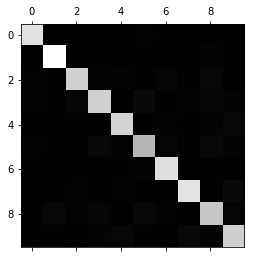

In [67]:
#Looking at the matrix in a plot
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that
they were classified correctly. The 5s look slightly darker than the other digits, which could mean that
there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other
digits. In fact, you can verify that both are the case.
Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the
number of images in the corresponding class, so you can compare error rates instead of absolute number
of errors (which would make abundant classes look unfairly bad):


In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

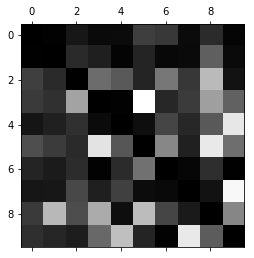

In [69]:
#Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual
classes, while columns represent predicted classes. The columns for classes 8 and 9 are quite bright,
which tells you that many images get misclassified as 8s or 9s. Similarly, the rows for classes 8 and 9 are
also quite bright, telling you that 8s and 9s are often confused with other digits. Conversely, some rows
are pretty dark, such as row 1: this means that most 1s are classified correctly (a few are confused with
8s, but that’s about it). Notice that the errors are not perfectly symmetrical; for example, there are more 5s
misclassified as 8s than the reverse.
